# Opis notatnika
Poniższy notatnik to dodatkowy notatnik, stworzony w celach przetestowania różnych parametrów sieci neuronowej i opcji biblioteki PyTorch w celu klasyfikacji jakości wina. Jest to dodatek do zadania laboratoryjnego, który robię we własnym zakresie

## Biblioteki

In [1]:
import pandas as pd
import torch
from torch import nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import torch.utils.data as data

## Wczytanie i prezentacja danych

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

columns = df.columns
data_values = df[columns[:-1]]
labels = df[columns[-1]]

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Confusion matrix

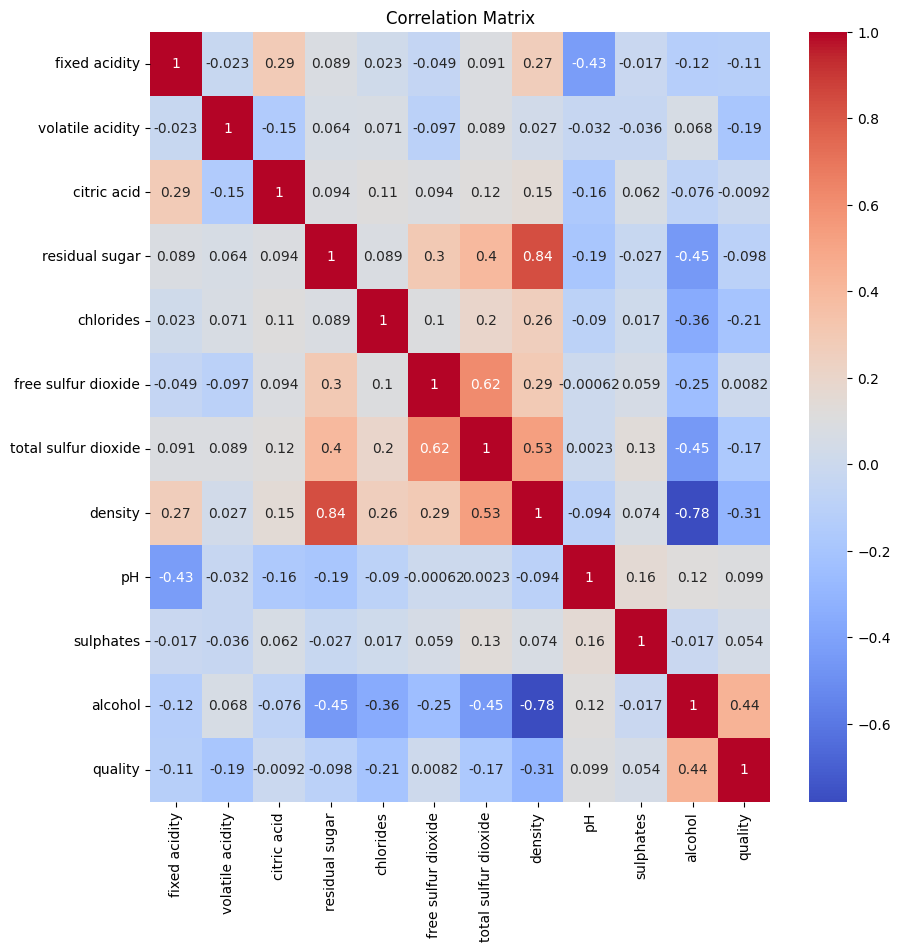

In [3]:
plt.figure(figsize=(10, 10))
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## Standaryzacja danych

In [4]:
scaler = StandardScaler()

# scale the data
scaled_data = scaler.fit_transform(data_values)

# transform data into a dataframe
scaled_data = pd.DataFrame(scaled_data, columns=columns[:-1])

labels -= 3

scaled_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203


## Przygotowanie modelu sieci

In [5]:
class WineQualityClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn=nn.ReLU(), dropout=0.0):
        super(WineQualityClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.activation = activation_fn
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


## Training Loop with Evaluation

In [6]:
def train(model, train_loader, test_loader, optimizer, loss_fn, device, epochs=100):

    history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct_train += (predicted == batch_y).sum().item()
            total_train += batch_y.size(0)

        train_loss /= len(train_loader)
        train_acc = correct_train / total_train

        # **Ewaluacja modelu**
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)

                test_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                correct_test += (predicted == batch_y).sum().item()
                total_test += batch_y.size(0)

        test_loss /= len(test_loader)
        test_acc = correct_test / total_test

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f'Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    return history


## Przygotowanie danych do treningu i testowania

In [7]:
# splitting data into train and test sets
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# changing into tensor
def change_data_to_tensor(X, y):
    dataset = data.TensorDataset(
    torch.from_numpy(X.values[:, :]).float(),
    torch.from_numpy(y.values).long()
)
    return dataset

# creating data loaders to load the data in batches
def get_data_loader(dataset, batch_size=32, if_shuffle=True):
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=if_shuffle)

## Testowanie dla różnych funkcji aktywacji

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

INPUT_FEATURES = df.shape[1] - 1
OUTPUT_FEATURES = df['quality'].nunique()
HIDDEN_FEATURES = 25

loss_func = nn.CrossEntropyLoss()


In [ ]:
def test_different_actication_functions(input_size, hidden_size, output_size, actv_functions_list, train_loader, test_loader, loss_func, device, epochs=100):

    history = {}

    for name, activation_fn in actv_functions_list:
        model = WineQualityClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size, activation_fn=activation_fn).to(device)
        model_parameters = model.parameters()
        optimizer = torch.optim.Adam(model_parameters, lr=0.008, weight_decay=1e-5)
        print(f'Training model with {name} activation function')
        history[name] = train(model, train_loader, test_loader, optimizer, loss_func, device, epochs=epochs)

    return history



In [26]:
X_train, X_test, y_train, y_test = split_data(scaled_data, labels)

train_dataset = change_data_to_tensor(X_train, y_train)
test_dataset = change_data_to_tensor(X_test, y_test)

train_loader = get_data_loader(train_dataset, batch_size=64, if_shuffle=False)
test_loader = get_data_loader(test_dataset, batch_size=64, if_shuffle=False)

actv_functions_list = [
    ('ReLU', nn.ReLU()),
    ('Sigmoid', nn.Sigmoid()),
    ('Tanh', nn.Tanh()),
    ('LeakyReLU', nn.LeakyReLU())
]

actv_history = test_different_actication_functions(INPUT_FEATURES, HIDDEN_FEATURES, OUTPUT_FEATURES, actv_functions_list, train_loader, test_loader, loss_func, device, epochs=100)

Training model with ReLU activation function
Epoch 0/100 - Train Loss: 1.2656, Test Loss: 1.1117, Train Acc: 0.5018, Test Acc: 0.5571
Epoch 1/100 - Train Loss: 1.0840, Test Loss: 1.0773, Train Acc: 0.5487, Test Acc: 0.5429
Epoch 2/100 - Train Loss: 1.0576, Test Loss: 1.0661, Train Acc: 0.5487, Test Acc: 0.5418
Epoch 3/100 - Train Loss: 1.0417, Test Loss: 1.0562, Train Acc: 0.5508, Test Acc: 0.5520
Epoch 4/100 - Train Loss: 1.0289, Test Loss: 1.0511, Train Acc: 0.5526, Test Acc: 0.5571
Epoch 5/100 - Train Loss: 1.0175, Test Loss: 1.0473, Train Acc: 0.5572, Test Acc: 0.5653
Epoch 6/100 - Train Loss: 1.0086, Test Loss: 1.0442, Train Acc: 0.5600, Test Acc: 0.5643
Epoch 7/100 - Train Loss: 1.0002, Test Loss: 1.0400, Train Acc: 0.5692, Test Acc: 0.5612
Epoch 8/100 - Train Loss: 0.9914, Test Loss: 1.0381, Train Acc: 0.5689, Test Acc: 0.5531
Epoch 9/100 - Train Loss: 0.9854, Test Loss: 1.0393, Train Acc: 0.5735, Test Acc: 0.5571
Epoch 10/100 - Train Loss: 0.9780, Test Loss: 1.0409, Train Acc: 

#### Plot of accuracy and plot of loss

In [27]:
def create_subplot_witch_acc_and_loss(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['test_loss'], label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['test_acc'], label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    fig.suptitle(title)
    plt.show()


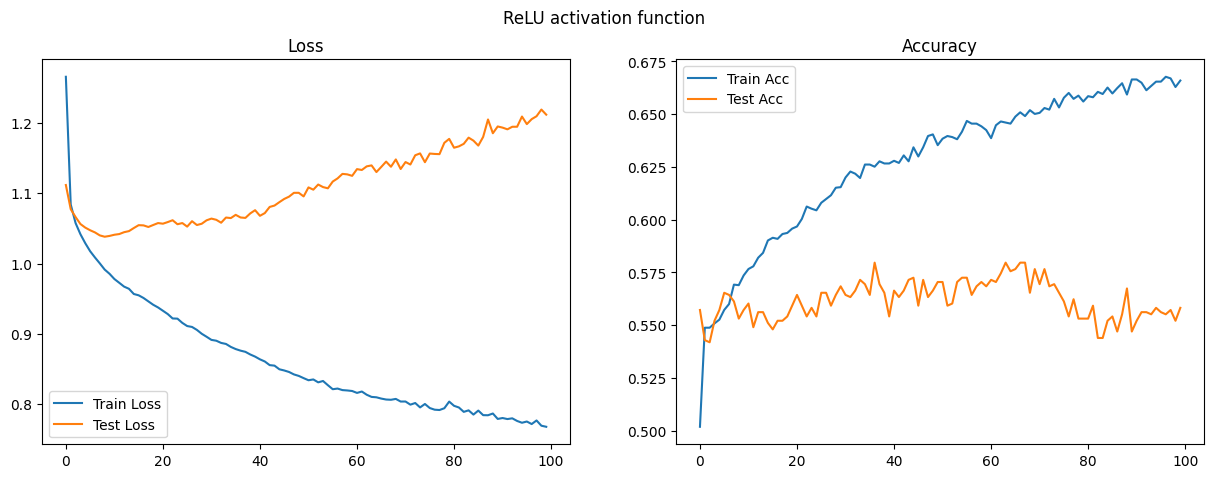

Average accuracy for ReLU activation function: 0.5618


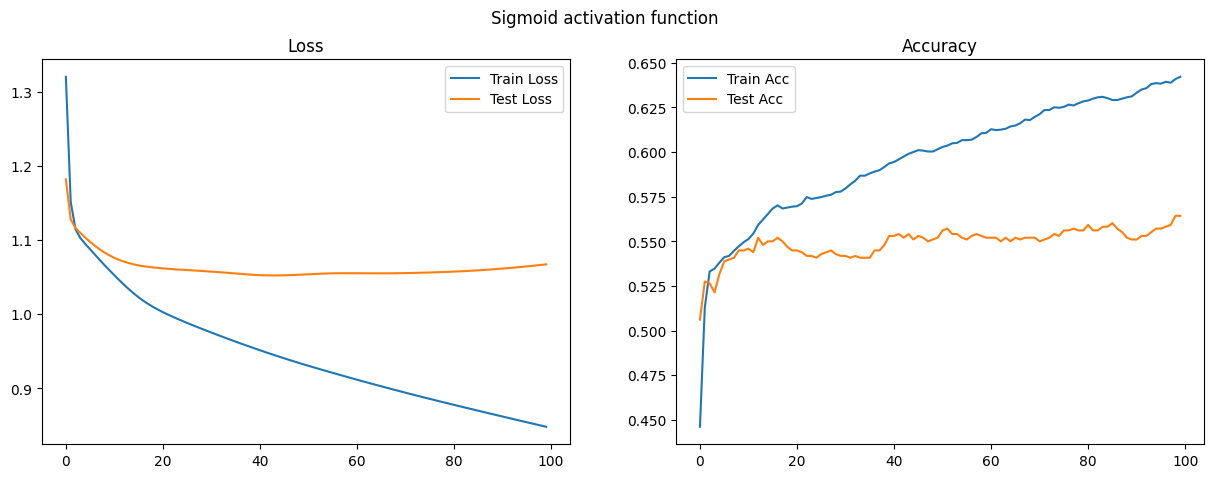

Average accuracy for Sigmoid activation function: 0.5493


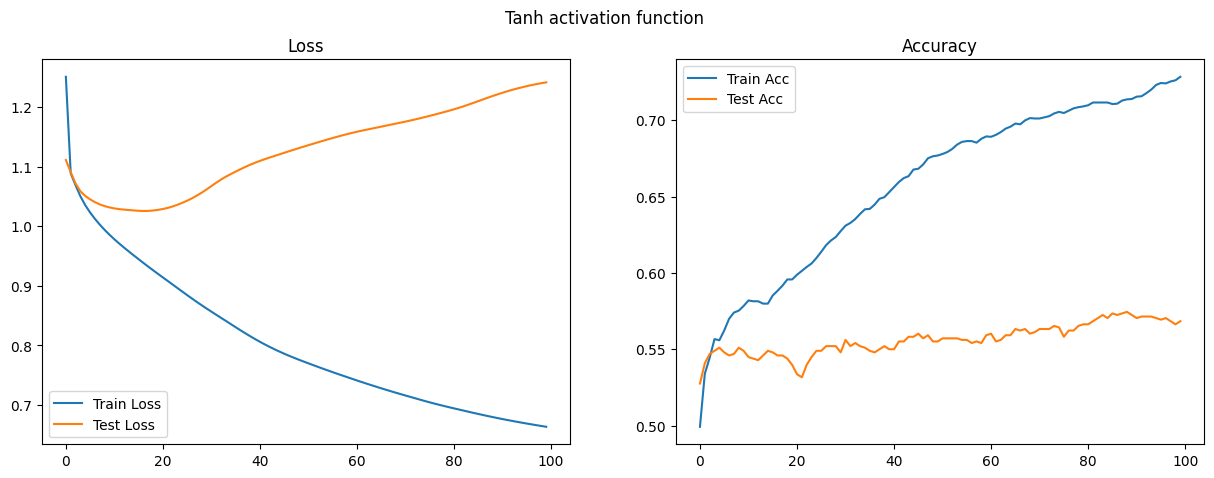

Average accuracy for Tanh activation function: 0.5564


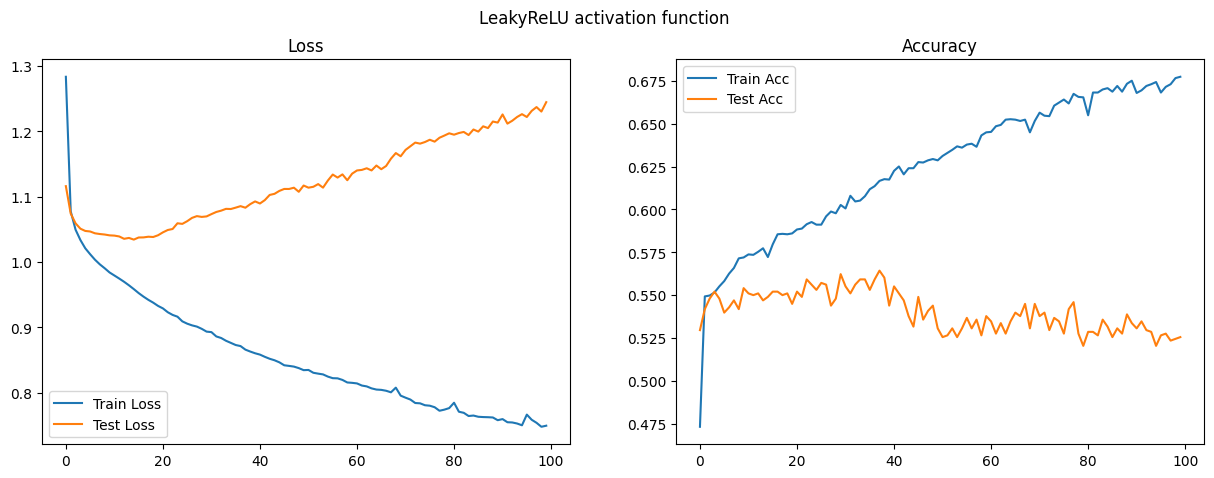

Average accuracy for LeakyReLU activation function: 0.5405


In [29]:
for name, history in actv_history.items():
    create_subplot_witch_acc_and_loss(history, name + ' activation function')
    avg_acc = np.mean(history['test_acc'])
    print(f'Average accuracy for {name} activation function: {avg_acc:.4f}')

## Testowanie dla różnych learning rate
-   Będę używał ReLU jako funkcja aktywacji, gdyż osiągnęła średnio najlepsze wyniki

In [32]:
def test_different_lr(input_size, hidden_size, output_size, learing_rates, train_loader, test_loader, loss_func, device, epochs=100):

    history = {}

    for lr in learing_rates:
        model = WineQualityClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size, activation_fn=nn.ReLU()).to(device)
        model_parameters = model.parameters()
        optimizer = torch.optim.Adam(model_parameters, lr=lr, weight_decay=1e-5)
        print(f'Training model with learning rate = {lr}')
        history[lr] = train(model, train_loader, test_loader, optimizer, loss_func, device, epochs=epochs)

    return history



Training model with learning rate = 0.0001
Epoch 0/100 - Train Loss: 1.8576, Test Loss: 1.8323, Train Acc: 0.2111, Test Acc: 0.2469
Epoch 1/100 - Train Loss: 1.8187, Test Loss: 1.7905, Train Acc: 0.2708, Test Acc: 0.3367
Epoch 2/100 - Train Loss: 1.7734, Test Loss: 1.7412, Train Acc: 0.3568, Test Acc: 0.4000
Epoch 3/100 - Train Loss: 1.7197, Test Loss: 1.6835, Train Acc: 0.4181, Test Acc: 0.4367
Epoch 4/100 - Train Loss: 1.6577, Test Loss: 1.6188, Train Acc: 0.4431, Test Acc: 0.4500
Epoch 5/100 - Train Loss: 1.5902, Test Loss: 1.5512, Train Acc: 0.4487, Test Acc: 0.4510
Epoch 6/100 - Train Loss: 1.5227, Test Loss: 1.4871, Train Acc: 0.4487, Test Acc: 0.4510
Epoch 7/100 - Train Loss: 1.4614, Test Loss: 1.4316, Train Acc: 0.4487, Test Acc: 0.4520
Epoch 8/100 - Train Loss: 1.4104, Test Loss: 1.3869, Train Acc: 0.4507, Test Acc: 0.4541
Epoch 9/100 - Train Loss: 1.3700, Test Loss: 1.3523, Train Acc: 0.4530, Test Acc: 0.4653
Epoch 10/100 - Train Loss: 1.3390, Test Loss: 1.3262, Train Acc: 0.

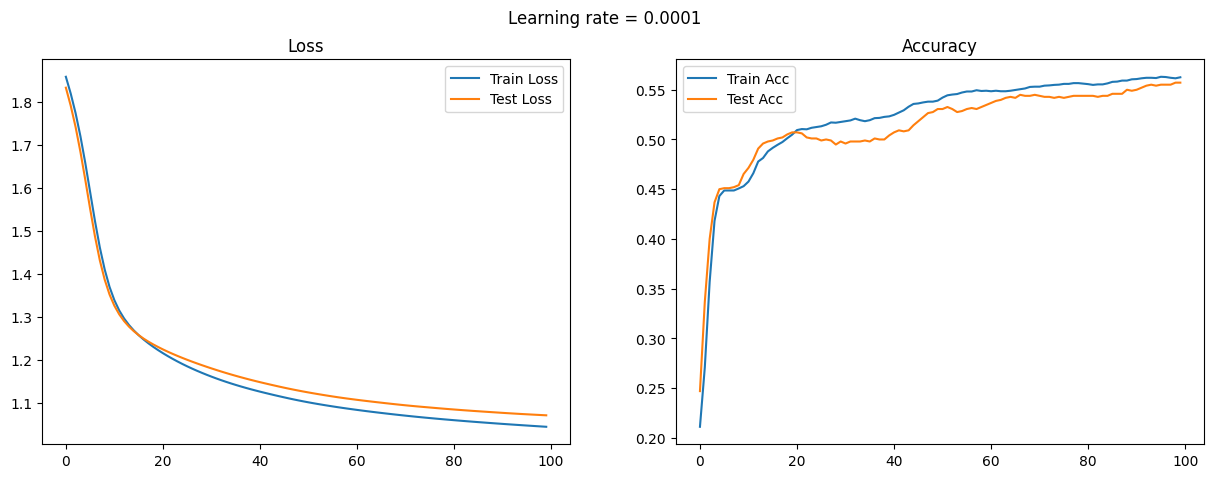

Average accuracy for learning rate = 0.0001: 0.5143


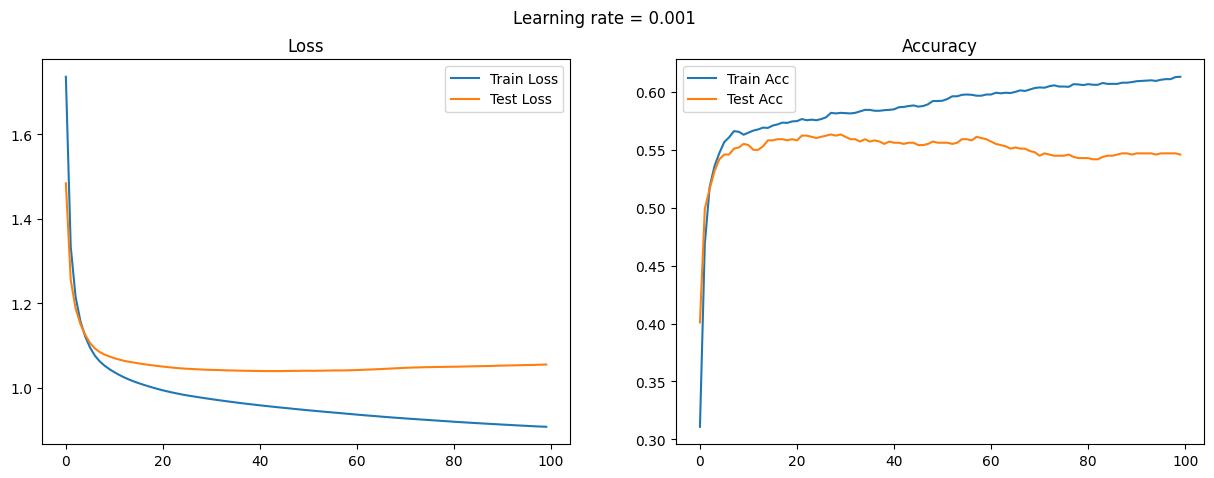

Average accuracy for learning rate = 0.001: 0.5502


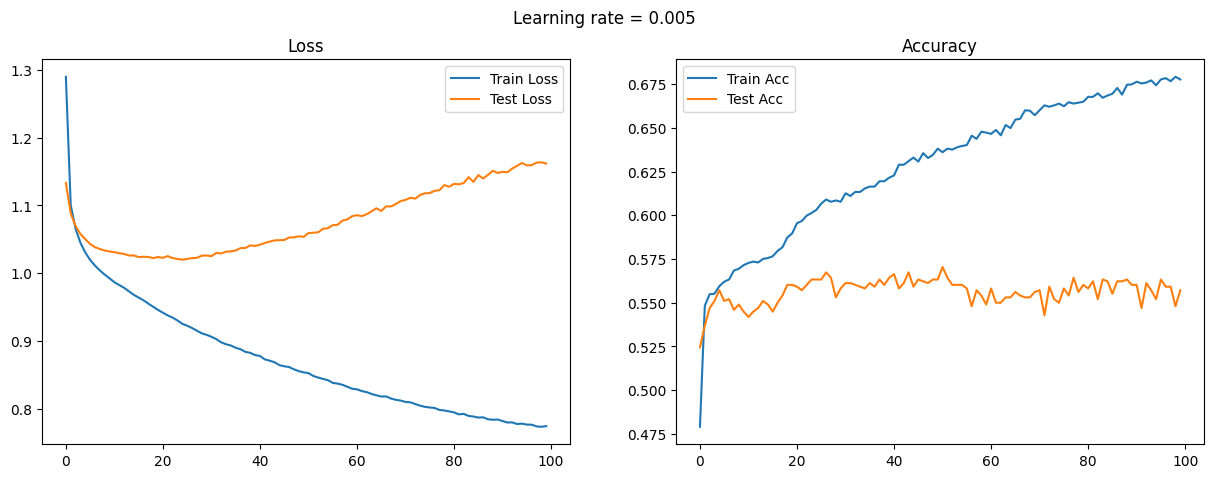

Average accuracy for learning rate = 0.005: 0.5564


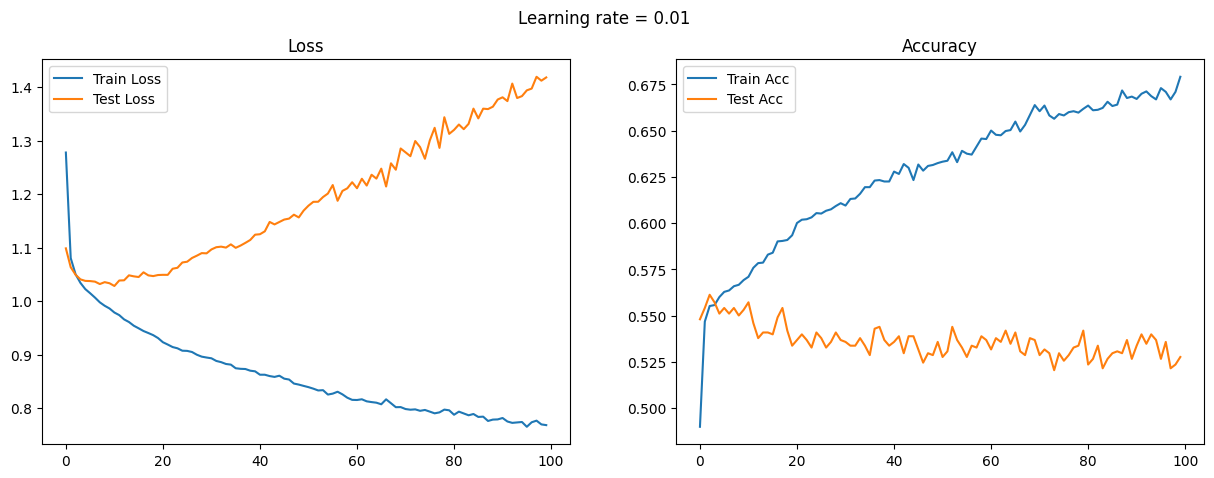

Average accuracy for learning rate = 0.01: 0.5364


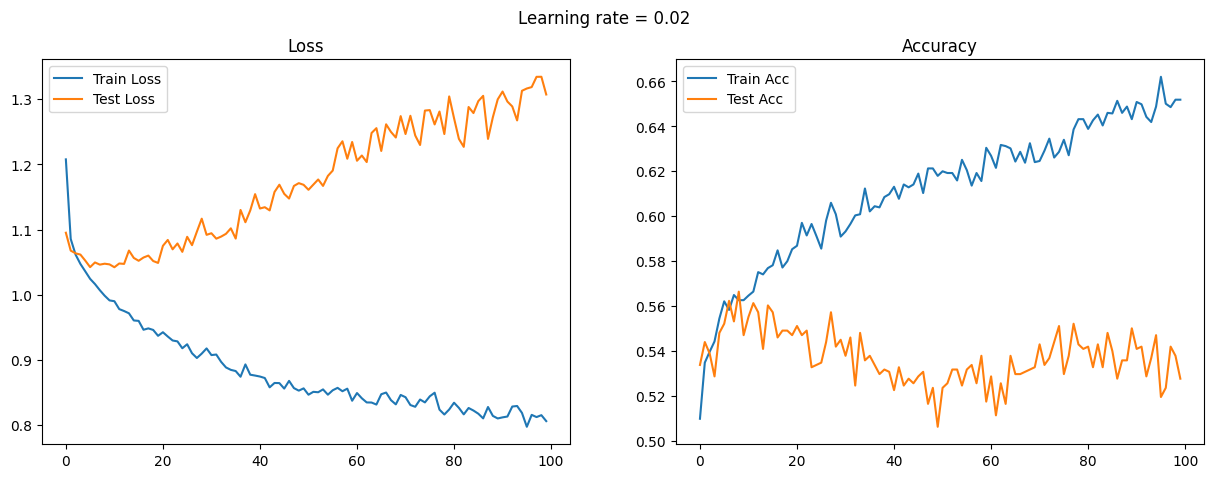

Average accuracy for learning rate = 0.02: 0.5372


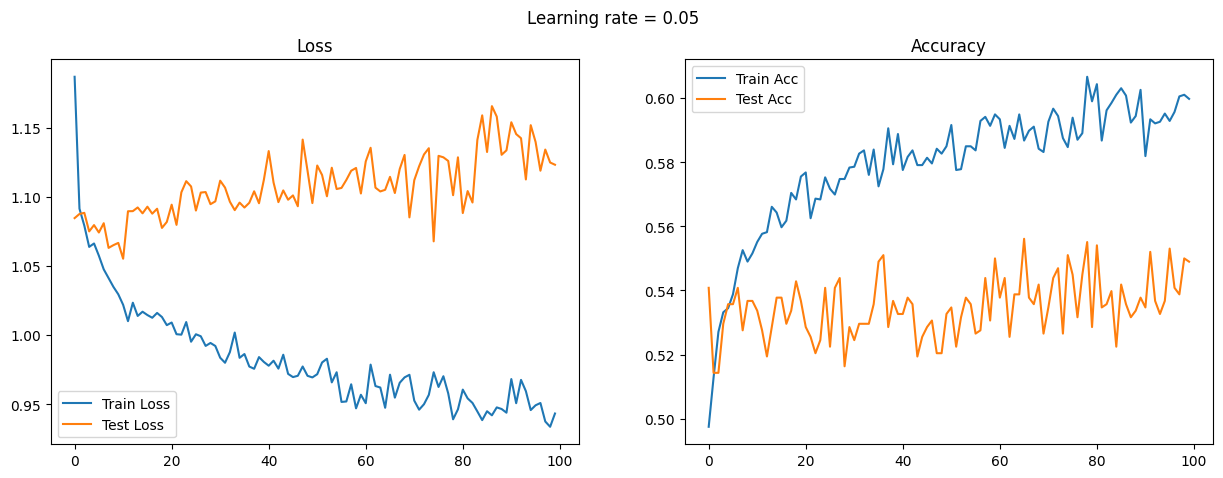

Average accuracy for learning rate = 0.05: 0.5349


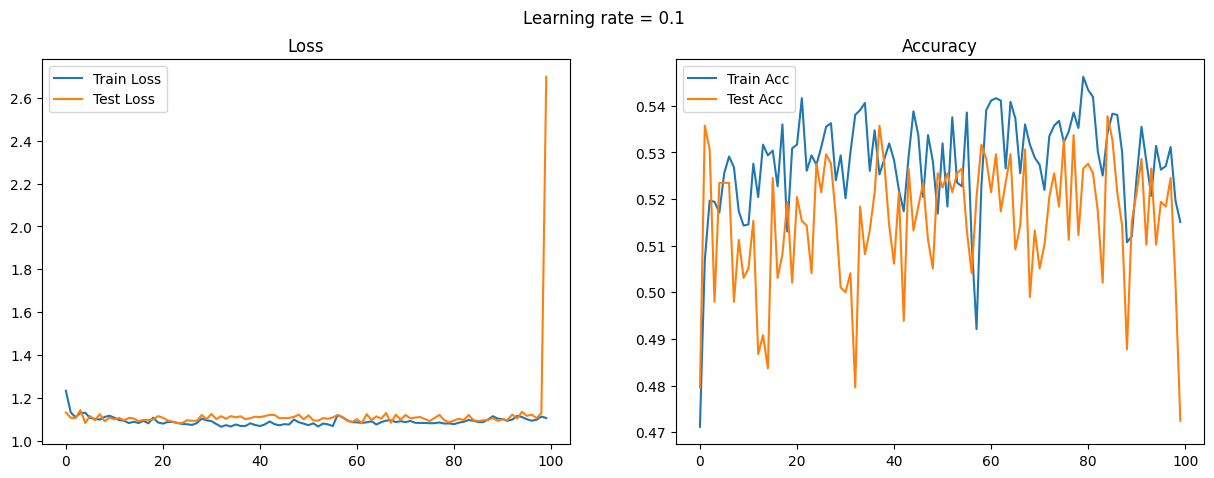

Average accuracy for learning rate = 0.1: 0.5153


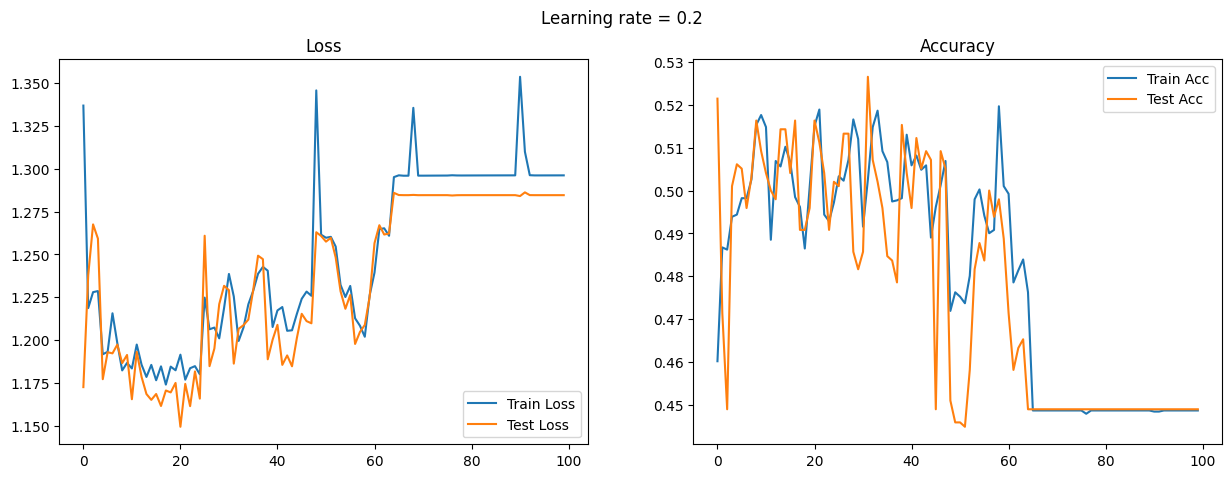

Average accuracy for learning rate = 0.2: 0.4770


In [33]:
learing_rates = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

lr_history = test_different_lr(INPUT_FEATURES, HIDDEN_FEATURES, OUTPUT_FEATURES, learing_rates, train_loader, test_loader, loss_func, device, epochs=100)

for lr, history in lr_history.items():
    create_subplot_witch_acc_and_loss(history, f'Learning rate = {lr}')
    avg_acc = np.mean(history['test_acc'])
    print(f'Average accuracy for learning rate = {lr}: {avg_acc:.4f}')